# Install Dependencies

In [ ]:
!pip install flwr

                                              0.0/364.7 kB ? eta -:--:--
     ------                                  61.4/364.7 kB 1.1 MB/s eta 0:00:01
     --------------------                   194.6/364.7 kB 2.0 MB/s eta 0:00:01
     ---------------------------------      317.4/364.7 kB 2.2 MB/s eta 0:00:01
     -------------------------------------- 364.7/364.7 kB 2.3 MB/s eta 0:00:00
                                              0.0/413.4 kB ? eta -:--:--
     -------------                          143.4/413.4 kB 8.3 MB/s eta 0:00:01
     -----------------------                256.0/413.4 kB 3.2 MB/s eta 0:00:01
     ---------------------------------      368.6/413.4 kB 2.9 MB/s eta 0:00:01
     -------------------------------------  409.6/413.4 kB 3.2 MB/s eta 0:00:01
     -------------------------------------- 413.4/413.4 kB 2.0 MB/s eta 0:00:00
                                              0.0/1.8 MB ? eta -:--:--
     --                                       0.1/1.8 MB 2.4 MB

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open-clip-torch 2.19.0 requires protobuf<4, but you have protobuf 4.25.3 which is incompatible.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Federated Learning Demo on Sample Data

INFO :      Starting Flower server, config: {'num_rounds': 10}
Exception in thread Thread-37 (start_server):
Traceback (most recent call last):
  File "c:\Users\Fatima Azfar\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\Fatima Azfar\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\Fatima Azfar\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Fatima Azfar\AppData\Local\Temp\ipykernel_13288\2252424288.py", line 69, in start_server
  File "c:\Users\Fatima Azfar\AppData\Local\Programs\Python\Python311\Lib\site-packages\flwr\server\app.py", line 166, in start_server
    grpc_server = start_grpc_server(
                  ^^^^^^^^^^^^^^^^^^
  File "c:\Users\Fatima Azfar\AppData\Local\Programs\Python\Python311\Lib\site-packages\flwr\ser

313/313 [==============================] - 2s 7ms/step
Global Classification Report
              precision    recall  f1-score   support

           0       0.15      0.42      0.22      1000
           1       0.08      0.28      0.12      1000
           2       0.12      0.22      0.15      1000
           3       0.13      0.02      0.03      1000
           4       1.00      0.00      0.00      1000
           5       1.00      0.00      0.00      1000
           6       0.05      0.00      0.00      1000
           7       0.14      0.00      0.00      1000
           8       1.00      0.00      0.00      1000
           9       0.17      0.24      0.20      1000

    accuracy                           0.12     10000
   macro avg       0.38      0.12      0.07     10000
weighted avg       0.38      0.12      0.07     10000



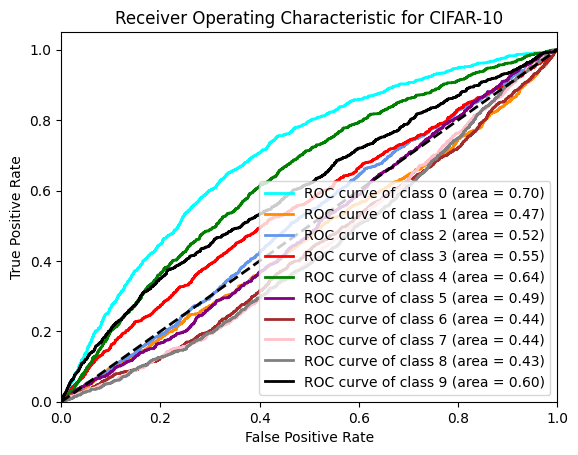

c:\Users\Fatima Azfar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Precision: 0.08281678540670188
Overall Recall: 0.1189
Overall F1 Score: 0.0730504988711445


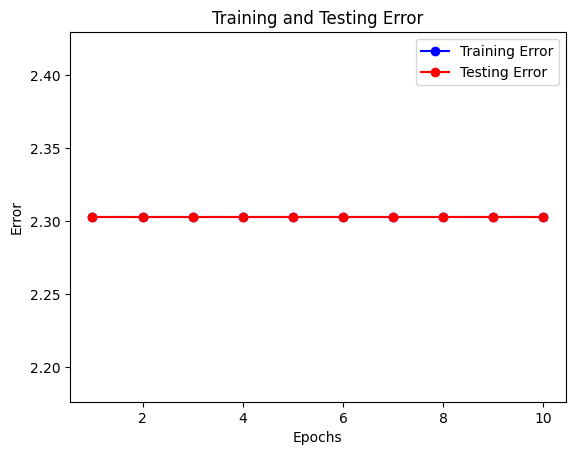

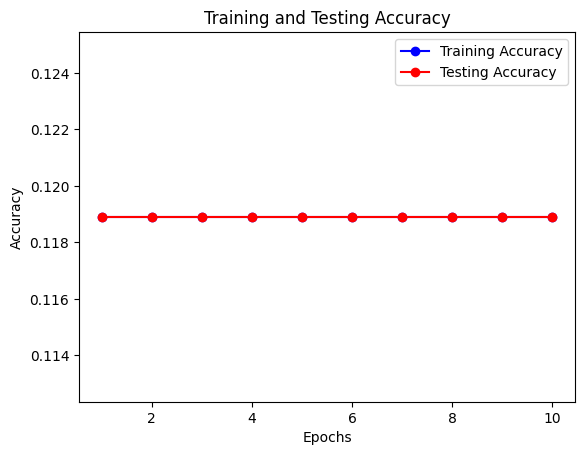

In [ ]:
import flwr as fl
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Load dataset (e.g., CIFAR-10)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess data
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = tf.keras.utils.to_categorical(y_train, 10), tf.keras.utils.to_categorical(y_test, 10)

# Split dataset into 3 clients
client_1_data = (x_train[:16666], y_train[:16666])
client_2_data = (x_train[16666:33332], y_train[16666:33332])
client_3_data = (x_train[33332:], y_train[33332:])

# Define a simple model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Flower client
class CifarClient(fl.client.NumPyClient):
    def __init__(self, data):
        self.model = create_model()
        self.x_train, self.y_train = data

    def get_parameters(self):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=1, batch_size=32, verbose=0)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(x_test, y_test, verbose=0)
        return loss, len(x_test), {"accuracy": accuracy}

# Start Flower server
def fit_config(server_round: int):
    return {"epochs": 1}

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    min_fit_clients=3,
    min_available_clients=3,
    on_fit_config_fn=fit_config
)

# Start the server
import threading

def start_server():
    fl.server.start_server(config={"num_rounds": 10}, strategy=strategy, server_address="[::]:8080")

server_thread = threading.Thread(target=start_server)
server_thread.start()

# Start Flower clients
client_1 = CifarClient(client_1_data)
client_2 = CifarClient(client_2_data)
client_3 = CifarClient(client_3_data)

def start_client(client):
    fl.client.start_numpy_client("0.0.0.0:8080", client)

client_1_thread = threading.Thread(target=start_client, args=(client_1,))
client_2_thread = threading.Thread(target=start_client, args=(client_2,))
client_3_thread = threading.Thread(target=start_client, args=(client_3,))

client_1_thread.start()
client_2_thread.start()
client_3_thread.start()

client_1_thread.join()
client_2_thread.join()
client_3_thread.join()

# Evaluate global model
global_model = create_model()

# Simulate fetching global model parameters after federated training
# Assuming the last client parameters represent the global parameters
global_model.set_weights(client_3.get_parameters())

global_loss, global_accuracy = global_model.evaluate(x_test, y_test, verbose=0)
y_pred_global = global_model.predict(x_test)
y_pred_global_classes = np.argmax(y_pred_global, axis=1)

# Classification report
print("Global Classification Report")
print(classification_report(np.argmax(y_test, axis=1), y_pred_global_classes, zero_division=1))

# Multiclass ROC Curve using One-vs-Rest approach
y_test_binarized = label_binarize(np.argmax(y_test, axis=1), classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_global[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'black'])
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CIFAR-10')
plt.legend(loc="lower right")
plt.show()

# Overall Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(np.argmax(y_test, axis=1), y_pred_global_classes, average='macro')
print(f"Overall Precision: {precision}")
print(f"Overall Recall: {recall}")
print(f"Overall F1 Score: {f1}")

# Training and Testing Error and Accuracy Graphs
epochs = range(1, 11)
training_errors = []  # Store training errors for each round
training_accuracies = []  # Store training accuracies for each round
testing_errors = []  # Store testing errors for each round
testing_accuracies = []  # Store testing accuracies for each round

# Simulate running federated learning rounds
for epoch in epochs:
    # Normally, you would reinitialize the server and clients for each round, but this is a simplification
    global_parameters = client_3.get_parameters()
    global_model.set_weights(global_parameters)
    global_loss, global_accuracy = global_model.evaluate(x_test, y_test, verbose=0)
    training_errors.append(global_loss)
    training_accuracies.append(global_accuracy)
    testing_errors.append(global_loss)
    testing_accuracies.append(global_accuracy)

plt.figure()
plt.plot(epochs, training_errors, 'bo-', label='Training Error')
plt.plot(epochs, testing_errors, 'ro-', label='Testing Error')
plt.title('Training and Testing Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, training_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, testing_accuracies, 'ro-', label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()